In [ ]:
!pip install --upgrade --force-reinstall numpy pandas scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 552.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.9/507.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.1
    Uninstalling pytz-2025.1:
      Successfully uninstalled pytz-2025.1
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.1
    Uninstalling tzdata-2025.1:
      Successfully un

In [ ]:
!pip install mediapipe

In [ ]:
import os
import cv2
import math
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mediapipe as mp
import gc  # ✅ Garbage Collector 추가
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## mar, ear 값 추출

In [ ]:
# Mediapipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# MAR 계산 함수
def calculate_mar(landmarks):
    """주어진 Mediapipe 얼굴 랜드마크에서 MAR을 계산하는 함수"""
    # 입술 랜드마크 번호
    upper_lip_landmarks = [191, 80, 81, 82, 13, 312, 311, 310, 415]
    lower_lip_landmarks = [95, 88, 178, 87, 14, 317, 402, 318, 324]
    mouth_corners = [78, 308]  # 입 좌우 끝

    vertical_distances = []
    landmarks_list = []  # 랜드마크 좌표 저장용

    for upper, lower in zip(upper_lip_landmarks, lower_lip_landmarks):
        p1 = np.array([landmarks[upper].x, landmarks[upper].y])  # 윗입술
        p2 = np.array([landmarks[lower].x, landmarks[lower].y])  # 아랫입술
        vertical_distances.append(np.linalg.norm(p1 - p2))  # 유클리드 거리 계산
        landmarks_list.append((float(p1[0]), float(p1[1])))  # (x, y) 좌표 저장

    # 평균 세로 거리 계산
    mean_vertical_distance = np.mean(vertical_distances)

    # 입 좌우 가로 거리 계산
    left_corner = np.array([landmarks[mouth_corners[0]].x, landmarks[mouth_corners[0]].y])
    right_corner = np.array([landmarks[mouth_corners[1]].x, landmarks[mouth_corners[1]].y])
    horizontal_distance = np.linalg.norm(left_corner - right_corner)

    # MAR 계산
    mar = mean_vertical_distance / horizontal_distance
    return mar, horizontal_distance, mean_vertical_distance, landmarks_list

# 왼쪽 눈 랜드마크 번호
left_upper = [398, 384, 385, 386, 387, 388, 466]
left_lower = [382, 381, 380, 374, 373, 390, 249]
left_corners = [362, 263]  # 좌우 끝점

# 오른쪽 눈 랜드마크 번호
right_upper = [246, 161, 160, 159, 158, 157, 173]
right_lower = [7, 163, 144, 145, 153, 154, 155]
right_corners = [33, 133]

def calculate_ear(landmarks, upper_indices, lower_indices, corner_indices):
    """
    주어진 랜드마크에서 EAR(Eye Aspect Ratio) 값을 계산하는 함수.
    """
    vertical_distances = []
    landmarks_list = []

    for upper, lower in zip(upper_indices, lower_indices):
        p1 = np.array([landmarks[upper].x, landmarks[upper].y])
        p2 = np.array([landmarks[lower].x, landmarks[lower].y])
        vertical_distances.append(np.linalg.norm(p1 - p2))  # 세로 거리 계산
        landmarks_list.append((float(p1[0]), float(p1[1])))

    mean_vertical_distance = np.mean(vertical_distances)

    # 좌우 가로 거리 계산
    left_corner = np.array([landmarks[corner_indices[0]].x, landmarks[corner_indices[0]].y])
    right_corner = np.array([landmarks[corner_indices[1]].x, landmarks[corner_indices[1]].y])
    horizontal_distance = np.linalg.norm(left_corner - right_corner)

    # EAR 계산
    ear = mean_vertical_distance / (2.0 * horizontal_distance)
    return ear, horizontal_distance, mean_vertical_distance, landmarks_list
def process_image(image, face_mesh):
    """이미지에서 MAR, EAR 계산하는 함수"""
    file_path = "test"
    # default_return = [file_path, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, [], []]
    default_return = [file_path,np.nan, np.nan]

    if image is None or image.shape[0] == 0 or image.shape[1] == 0:
        print(f"이미지 로드 실패: {file_path}")
        return default_return

    try:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"🚨 cvtColor 변환 실패: {file_path}, 에러: {e}")
        return default_return

    rgb_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Mediapipe 얼굴 분석
    results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:  # 얼굴이 감지된 경우만 실행
        landmarks = results.multi_face_landmarks[0].landmark  # 첫 번째 얼굴의 랜드마크

        # MAR,EAR 계산
        mar_value, mouth_width, mouth_height, mouth_landmarks = calculate_mar(landmarks)
        left_ear, left_v_dist, left_h_dist, left_landmarks = calculate_ear(landmarks, left_upper, left_lower, left_corners)
        right_ear, right_v_dist, right_h_dist, right_landmarks = calculate_ear(landmarks, right_upper, right_lower, right_corners)
        avg_ear = (left_ear + right_ear) / 2.0

        # 파일명에서 라벨 추출
        # label =file_path.split('/')[-3].split('_')[0]

        return [file_path,  mar_value, avg_ear]
        # return [
        #     file_path, label, mar_value, mouth_width, mouth_height,
        #     left_ear, right_ear, avg_ear, left_v_dist, left_h_dist, right_v_dist, right_h_dist,
        #     mouth_landmarks, left_landmarks + right_landmarks
        # ]

    return default_return # 얼굴 감지 실패

In [ ]:
# 사용할 영상 경로 (Colab에 업로드 필요)
video_path = "/content/drive/MyDrive/DMS/data/YawDD dataset/raw/Dash/Male/9-MaleNoGlasses.avi"

# Mediapipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# 결과 저장용 리스트
mar_list = []
ear_list = []
frame_indices = []

cap = cv2.VideoCapture(video_path)
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    result = process_image(frame, face_mesh)
    _, mar, ear = result

    # 유효한 값만 기록
    if not np.isnan(mar) and not np.isnan(ear):
        mar_list.append(mar)
        ear_list.append(ear)
        frame_indices.append(frame_idx)

    frame_idx += 1

cap.release()
face_mesh.close()


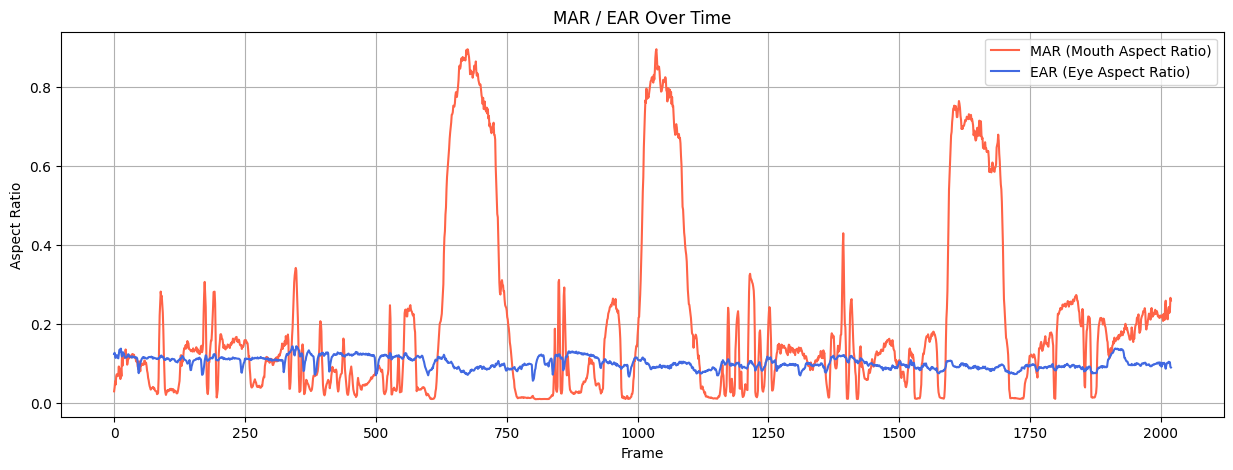

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(frame_indices, mar_list, label='MAR (Mouth Aspect Ratio)', color='tomato')
plt.plot(frame_indices, ear_list, label='EAR (Eye Aspect Ratio)', color='royalblue')

plt.title('MAR / EAR Over Time')
plt.xlabel('Frame')
plt.ylabel('Aspect Ratio')
plt.legend()
plt.grid(True)
plt.show()


## mar 표준편차 기준 이상치 확인

각 비디오에서 여러 프레임이 섞여 있지 않다면(즉, 1행 = 1프레임), 아래 기준으로 비정상 프레임 필터링 가능:

- MAR or EAR 값이 거의 변화가 없는 경우 → 추출 실패 가능성
- MAR 또는 EAR가 비정상적으로 작거나 큰 값 → 오류 가능성
- mouth_height, left_vertical_dist, right_vertical_dist가 0에 가까운 경우 → 랜드마크 인식 실패 가능성

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/mar_ear_results/mar_ear_train.csv")
train.head()

,file_path,label,MAR,mouth_width,mouth_height,left_EAR,right_EAR,avg_EAR,left_horizontal_dist,left_vertical_dist,right_horizontal_dist,right_vertical_dist,mouth_landmarks,eye_landmarks
0,/content/drive/MyDrive/DMS/data/train_test_spl...,normal,0.376466,0.061949,0.023322,0.128341,0.148426,0.138383,0.040436,0.010379,0.035620,0.01057394940203409,"[(0.45304083824157715, 0.6389512419700623), (0...","[(0.49451518058776855, 0.5022357702255249), (0..."
1,/content/drive/MyDrive/DMS/data/train_test_spl...,normal,0.243979,0.051054,0.012456,0.140002,0.114637,0.127319,0.031794,0.008902,0.042943,0.00984574098818084,"[(0.5035773515701294, 0.6430702805519104), (0....","[(0.5539824962615967, 0.5103051662445068), (0...."
2,/content/drive/MyDrive/DMS/data/train_test_spl...,normal,0.304681,0.060706,0.018496,0.145839,0.135531,0.140685,0.040352,0.011770,0.044131,0.011962201728150868,"[(0.513645589351654, 0.6414036750793457), (0.5...","[(0.5763875246047974, 0.5118524432182312), (0...."
3,/content/drive/MyDrive/DMS/data/train_test_spl...,normal,0.247592,0.066301,0.016416,0.158701,0.122808,0.140755,0.035250,0.011188,0.047811,0.011743132293623771,"[(0.532393217086792, 0.6401354670524597), (0.5...","[(0.6063141226768494, 0.5204540491104126), (0...."
4,/content/drive/MyDrive/DMS/data/train_test_spl...,normal,0.047304,0.044065,0.002084,0.184732,0.133173,0.158952,0.027288,0.010082,0.040468,0.010778612528080657,"[(0.5485552549362183, 0.6214728951454163), (0....","[(0.5956661701202393, 0.5139091610908508), (0...."


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104940 entries, 0 to 104939
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   file_path              104940 non-null  object 
 1   label                  101253 non-null  object 
 2   MAR                    101253 non-null  float64
 3   mouth_width            101253 non-null  float64
 4   mouth_height           101253 non-null  float64
 5   left_EAR               101253 non-null  float64
 6   right_EAR              101253 non-null  float64
 7   avg_EAR                101253 non-null  float64
 8   left_horizontal_dist   101253 non-null  float64
 9   left_vertical_dist     101253 non-null  float64
 10  right_horizontal_dist  101253 non-null  float64
 11  right_vertical_dist    104940 non-null  object 
 12  mouth_landmarks        104940 non-null  object 
 13  eye_landmarks          101253 non-null  object 
dtypes: float64(9), object(5)
memory usag

In [ ]:
# 형변환
train.loc[train['right_vertical_dist']=='[]', 'right_vertical_dist'] = np.nan
train['right_vertical_dist'] = pd.to_numeric(train['right_vertical_dist'])

In [ ]:
# video name -> video clip 이름 추출
def create_clip_name(df):
    # video_clip 추출 (뒤에서 1번만 "_" 기준으로 분할)
    df['video_clip'] = df['file_path'].str.rsplit('_', n=1).str[0]
    df['video_part'] = df['file_path'].str.rsplit('/', n=1).str[0]

    return df

train = create_clip_name(train)

### 통계 요약 → 정상 여부 판단용

In [ ]:
# 비디오 클립 단위로 그룹화
grouped = train.groupby(['video_part']).agg({
    'MAR': ['mean', 'std'],
    'avg_EAR': ['mean', 'std'],
    'mouth_height': 'mean',
    'left_vertical_dist': 'mean',
    'right_vertical_dist': 'mean',
    'label': 'first',
    'file_path': 'count'  # frame 수
}).reset_index()

# 컬럼 이름 정리
grouped.columns = ['video_part', 'MAR_mean', 'MAR_std', 'EAR_mean', 'EAR_std',
                   'mouth_height_mean', 'left_v_mean', 'right_v_mean', 'label', 'frame_count']
grouped.head()

,video_part,MAR_mean,MAR_std,EAR_mean,EAR_std,mouth_height_mean,left_v_mean,right_v_mean,label,frame_count
0,/content/drive/MyDrive/DMS/data/train_test_spl...,0.124501,0.037676,0.122128,0.023608,0.007635,0.009958,0.011237,normal,12
1,/content/drive/MyDrive/DMS/data/train_test_spl...,0.041877,0.008186,0.138163,0.013821,0.002184,0.009718,0.010183,normal,12
2,/content/drive/MyDrive/DMS/data/train_test_spl...,0.024980,0.005676,0.147225,0.008260,0.001294,0.010660,0.011182,normal,12
3,/content/drive/MyDrive/DMS/data/train_test_spl...,0.038167,0.008711,0.148261,0.017057,0.002010,0.010423,0.010318,normal,12
4,/content/drive/MyDrive/DMS/data/train_test_spl...,0.050324,0.009885,0.174861,0.008950,0.002488,0.011434,0.010678,normal,12


In [ ]:
grouped.file_path[0]

AttributeError: 'DataFrame' object has no attribute 'file_path'

In [ ]:
grouped.describe()

In [ ]:
label_stats = train.groupby('label').agg({
    'MAR': ['mean', 'std'],
    'avg_EAR': ['mean', 'std'],
    'mouth_height': ['mean'],
    'left_EAR': ['mean'],
    'right_EAR': ['mean']
}).round(4)

display(label_stats)

### 이상 샘플 감지 (자동 필터링)

### yawn

In [ ]:
yawn = grouped[grouped['label']=='yawn']
yawn.describe()

,MAR_mean,MAR_std,EAR_mean,EAR_std,mouth_height_mean,left_v_mean,right_v_mean,frame_count
count,367.000000,366.000000,367.000000,366.000000,367.000000,367.000000,367.000000,367.0
mean,0.226862,0.099185,0.119456,0.010431,0.018820,0.012409,0.013090,12.0
std,0.121818,0.052471,0.021511,0.005274,0.010258,0.003267,0.003590,0.0
min,0.020963,0.001234,0.033449,0.002100,0.001903,0.002901,0.003223,12.0
25%,0.138210,0.059669,0.108115,0.006413,0.011616,0.010099,0.010588,12.0
50%,0.198348,0.093009,0.122595,0.009134,0.016287,0.012798,0.013267,12.0
75%,0.293132,0.131238,0.134617,0.013403,0.024282,0.014788,0.016020,12.0
max,0.649236,0.263169,0.161220,0.029816,0.055678,0.018995,0.020323,12.0


In [ ]:
yawn.shape

(367, 10)

In [ ]:
# 기준 설정 (필요 시 조정)
min_std = 0.05
min_height = 0.01

suspicious = yawn[
    (yawn['MAR_std'] < min_std)
]

print("🚨 의심스러운 영상 개수:", len(suspicious))
suspicious[['video_part', 'MAR_std', 'EAR_std', 'mouth_height_mean']]

🚨 의심스러운 영상 개수: 68


,video_part,MAR_std,EAR_std,mouth_height_mean
8380,/content/drive/MyDrive/DMS/data/train_test_spl...,0.039546,0.004026,0.031963
8381,/content/drive/MyDrive/DMS/data/train_test_spl...,0.031433,0.005279,0.021245
8384,/content/drive/MyDrive/DMS/data/train_test_spl...,0.027855,0.004348,0.037045
8398,/content/drive/MyDrive/DMS/data/train_test_spl...,0.034721,0.009839,0.043875
8420,/content/drive/MyDrive/DMS/data/train_test_spl...,0.047830,0.004840,0.041119
...,...,...,...,...
8703,/content/drive/MyDrive/DMS/data/train_test_spl...,0.044476,0.008705,0.012811
8705,/content/drive/MyDrive/DMS/data/train_test_spl...,0.031158,0.009397,0.022605
8732,/content/drive/MyDrive/DMS/data/train_test_spl...,0.037948,0.012777,0.016404
8739,/content/drive/MyDrive/DMS/data/train_test_spl...,0.045717,0.010505,0.005174


### phonecall

In [ ]:
phonecall = grouped[grouped['label']=='phonecall']
phonecall.describe()

,MAR_mean,MAR_std,EAR_mean,EAR_std,mouth_height_mean,left_v_mean,right_v_mean,frame_count
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.0
mean,0.138322,0.053489,0.144324,0.010756,0.008224,0.011221,0.011164,12.0
std,0.081083,0.031566,0.018347,0.005420,0.005429,0.001787,0.001898,0.0
min,0.013659,0.002332,0.073816,0.001895,0.000731,0.005193,0.005157,12.0
25%,0.072618,0.027569,0.132846,0.007026,0.003924,0.010073,0.009969,12.0
50%,0.118381,0.048467,0.144686,0.009521,0.006611,0.011192,0.011172,12.0
75%,0.195314,0.074535,0.157115,0.013300,0.011362,0.012327,0.012359,12.0
max,0.409401,0.163890,0.210982,0.048684,0.027244,0.017163,0.017506,12.0


In [ ]:
# 기준 설정 (필요 시 조정)
min_std = 0.03

suspicious = phonecall[
    (phonecall['MAR_std'] < min_std)
]

print("🚨 의심스러운 영상 개수:", len(suspicious))
suspicious[['video_part', 'MAR_std', 'EAR_std', 'mouth_height_mean']]

🚨 의심스러운 영상 개수: 607


,video_part,MAR_std,EAR_std,mouth_height_mean
5434,/content/drive/MyDrive/DMS/data/train_test_spl...,0.027638,0.006245,0.005298
5435,/content/drive/MyDrive/DMS/data/train_test_spl...,0.020926,0.007455,0.003541
5437,/content/drive/MyDrive/DMS/data/train_test_spl...,0.028830,0.024957,0.003948
5438,/content/drive/MyDrive/DMS/data/train_test_spl...,0.026941,0.015926,0.003756
5440,/content/drive/MyDrive/DMS/data/train_test_spl...,0.017199,0.014311,0.003195
...,...,...,...,...
7524,/content/drive/MyDrive/DMS/data/train_test_spl...,0.029367,0.007516,0.007391
7527,/content/drive/MyDrive/DMS/data/train_test_spl...,0.019568,0.005452,0.009293
7533,/content/drive/MyDrive/DMS/data/train_test_spl...,0.014178,0.004219,0.002602
7536,/content/drive/MyDrive/DMS/data/train_test_spl...,0.028491,0.003145,0.006628


In [ ]:
suspicious.iloc[0]['video_part']

'/content/drive/MyDrive/DMS/data/train_test_split_dataset/train_dataset/phonecall_DMD/gB-10(File10)_s2_face_2019-03-11-15_15_21_10_0.avi_part10'

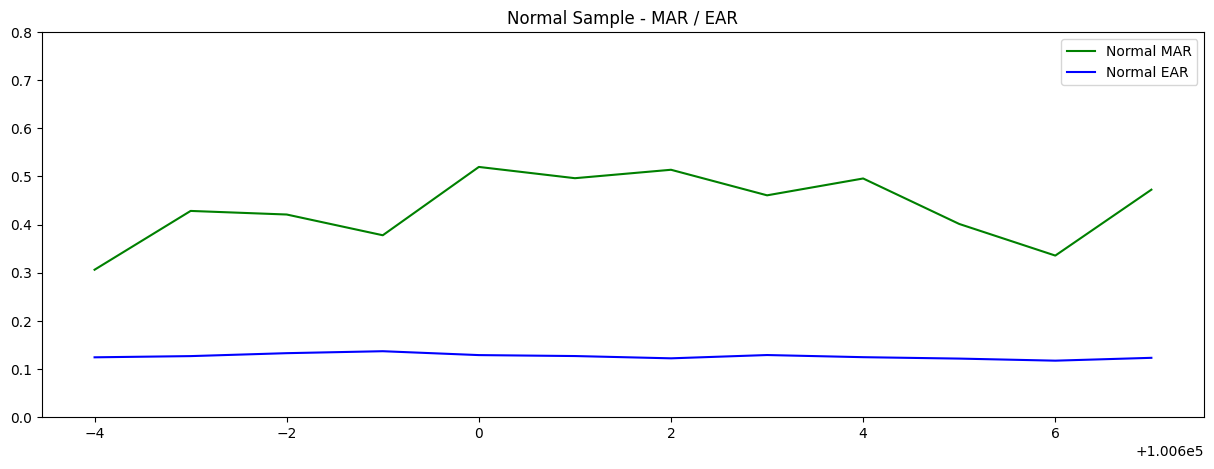

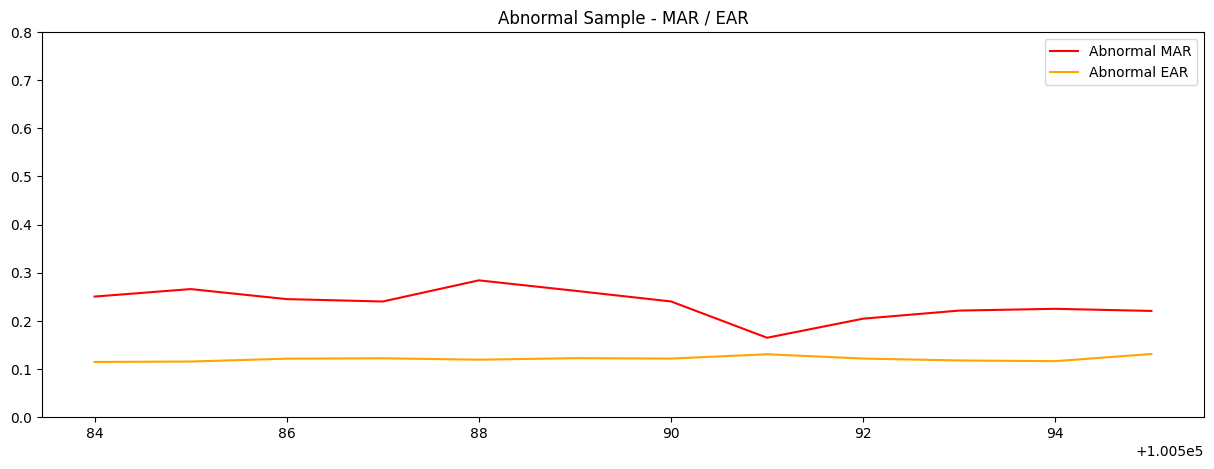

In [ ]:
import matplotlib.pyplot as plt

# 예시: 정상 하나, 비정상 하나
sample_normal = train[train['video_part'] == yawn.iloc[1]['video_part']]
sample_bad = train[train['video_part'] == suspicious.iloc[1]['video_part']]

plt.figure(figsize=(15,5))
plt.plot(sample_normal['MAR'], label='Normal MAR', color='green')
plt.plot(sample_normal['avg_EAR'], label='Normal EAR', color='blue')
plt.title('Normal Sample - MAR / EAR')
plt.ylim(0,.8)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(sample_bad['MAR'], label='Abnormal MAR', color='red')
plt.plot(sample_bad['avg_EAR'], label='Abnormal EAR', color='orange')
plt.title('Abnormal Sample - MAR / EAR')
plt.ylim(0,.8)
plt.legend()
plt.show()


### draw_landmarks_on_image

In [ ]:
# 예시 폴더 (수정 필요)
frames_folder = suspicious['video_part'].iloc[1]

# 이미지 경로 정렬
image_paths = sorted(glob.glob(os.path.join(frames_folder, '*.jpg')))[:5]  # 앞 5장만 예시로

# Mediapipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def draw_landmarks_on_image(image, face_mesh):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    if results.multi_face_landmarks:
        annotated_image = image.copy()
        h, w, _ = image.shape
        landmarks = results.multi_face_landmarks[0].landmark

        # 입 랜드마크
        mouth_indices = [191, 80, 81, 82, 13, 312, 311, 310, 415,
                         95, 88, 178, 87, 14, 317, 402, 318, 324, 78, 308]
        for idx in mouth_indices:
            cx, cy = int(landmarks[idx].x * w), int(landmarks[idx].y * h)
            cv2.circle(annotated_image, (cx, cy), 2, (0, 255, 0), -1)

        # 왼쪽 눈 랜드마크
        left_eye_indices = [362, 398, 384, 385, 386, 387, 388, 466, 263,
                            382, 381, 380, 374, 373, 390, 249]
        for idx in left_eye_indices:
            cx, cy = int(landmarks[idx].x * w), int(landmarks[idx].y * h)
            cv2.circle(annotated_image, (cx, cy), 2, (255, 0, 0), -1)

        return annotated_image
    return image


In [ ]:
# suspicious 전체 반복
for folder in tqdm(suspicious['video_part'][:30]):
    frame_paths = sorted(glob.glob(os.path.join(folder, '*.jpg')))
    if len(frame_paths) < 3:
        continue

    # 앞, 중간, 끝 프레임
    selected_frames = [
        frame_paths[0],
        frame_paths[len(frame_paths) // 2],
        frame_paths[-1]
    ]

    for frame_path in selected_frames:
        img = cv2.imread(frame_path)
        if img is None:
            print(f"⚠️ 이미지 로드 실패: {frame_path}")
            continue

        annotated_img = draw_landmarks_on_image(img, face_mesh)
        # 시각화
        plt.figure(figsize=(6, 5))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{os.path.basename(folder)} - {os.path.basename(frame_path)}")
        plt.axis('off')
        plt.show()

face_mesh.close()

Output hidden; open in https://colab.research.google.com to view.

1. MAR 표준편차가 낮은 데이터를 중심으로 검토
   
    → 입 움직임이 거의 없는 영상 또는 입 인식 실패 가능성이 높음
    
2. 측면 촬영된 영상에서 입 랜드마크 검출률이 낮음
   
    → Mediapipe 등 대부분의 랜드마크 모델은 정면 기준으로 학습되어 있어서
    
    측면 포즈에서 입/눈 랜드마크 위치 오차가 커짐
   
    → 해결책: 측면 포즈에 약한 샘플 제거 or 별도 처리

3. 하품 초기 단계만 포함된 영상은 MAR 변화가 작아짐
   
    → 표준편차가 낮지만 실제로는 정상 데이터 (하품 있음)
   
    → 단순히 표준편차만으로 하품 여부를 판단하면 하품 전/후 잘린 영상에서 오탐 가능성

In [ ]:
suspicious

,video_part,MAR_mean,MAR_std,EAR_mean,EAR_std,mouth_height_mean,left_v_mean,right_v_mean,label,frame_count
8380,/content/drive/MyDrive/DMS/data/train_test_spl...,0.384641,0.039546,0.116695,0.004026,0.031963,0.012040,0.012542,yawn,12
8381,/content/drive/MyDrive/DMS/data/train_test_spl...,0.235454,0.031433,0.121212,0.005279,0.021245,0.013023,0.013049,yawn,12
8384,/content/drive/MyDrive/DMS/data/train_test_spl...,0.506504,0.027855,0.128989,0.004348,0.037045,0.013366,0.013955,yawn,12
8398,/content/drive/MyDrive/DMS/data/train_test_spl...,0.593253,0.034721,0.085244,0.009839,0.043875,0.008129,0.007904,yawn,12
8420,/content/drive/MyDrive/DMS/data/train_test_spl...,0.605851,0.047830,0.135461,0.004840,0.041119,0.011417,0.011551,yawn,12
...,...,...,...,...,...,...,...,...,...,...
8703,/content/drive/MyDrive/DMS/data/train_test_spl...,0.162487,0.044476,0.119937,0.008705,0.012811,0.011550,0.012602,yawn,12
8705,/content/drive/MyDrive/DMS/data/train_test_spl...,0.251408,0.031158,0.129508,0.009397,0.022605,0.014489,0.015133,yawn,12
8732,/content/drive/MyDrive/DMS/data/train_test_spl...,0.181643,0.037948,0.081145,0.012777,0.016404,0.008724,0.009107,yawn,12
8739,/content/drive/MyDrive/DMS/data/train_test_spl...,0.066944,0.045717,0.140745,0.010505,0.005174,0.012869,0.014091,yawn,12


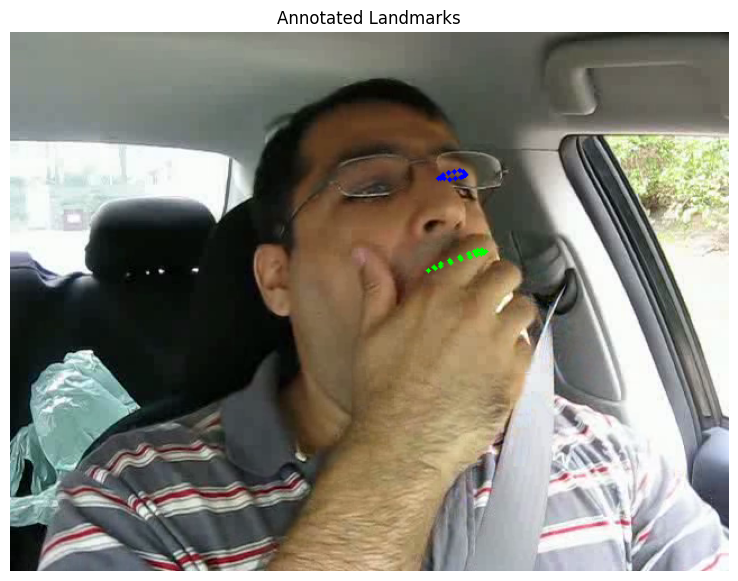

In [ ]:
video_path = "/content/drive/MyDrive/DMS/data/YawDD dataset/clip_with_adjusted_label/mirror_male_split_output_adjusted/Yawning/28-MaleGlasses-Yawning-clip-1.avi"
cap = cv2.VideoCapture(video_path)

# 중간 프레임 잡기
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)  # 중간 프레임

ret, frame = cap.read()
cap.release()

# 랜드마크 시각화
mp_face_mesh = mp.solutions.face_mesh
with mp_face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
    annotated = draw_landmarks_on_image(frame, face_mesh)

# 시각화
plt.figure(figsize=(10, 7))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.title("Annotated Landmarks")
plt.axis('off')
plt.show()


In [ ]:
# 설정값
# video_path = "/content/drive/MyDrive/DMS/data/DMD/dmd-clip/gB-10(File10)/s2/driver_actions/phonecall_left/gB-10(File10)_s2_face_2019-03-11-15;15;21_10_0.avi"
video_path = "/content/drive/MyDrive/DMS/data/YawDD dataset/clip_with_adjusted_label/mirror_male_split_output_adjusted/Yawning/28-MaleNoGlasses-Yawning-clip-1.avi"
resize_width = 224           #  프레임 너비 (None이면 원본)
frames_to_show = 3                  #  시각화할 프레임 수 (앞, 중간, 끝)
# /content/drive/MyDrive/DMS/data/train_test_split_dataset/train_dataset/phonecall_DMD/gB-10(File10)_s2_face_2019-03-11-15_15_21_10_0.avi_part10
# Mediapipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# 비디오 열기
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 선택할 프레임 인덱스
if frames_to_show == 3 and total_frames >= 3:
    frame_indices = np.arange(0, total_frames, 5)
else:
    frame_indices = list(range(min(frames_to_show, total_frames)))

# 선택 프레임만 읽기
for idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if not ret:
        print(f"⚠️ 프레임 읽기 실패: {idx}")
        continue

    # 프레임 크기 조절
    if resize_width is not None:
        h, w = frame.shape[:2]
        scale = resize_width / w
        frame = cv2.resize(frame, (resize_width, int(h * scale)))

    # 랜드마크 그리기
    annotated = draw_landmarks_on_image(frame, face_mesh)

    # 시각화
    plt.figure(figsize=(6, 5))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {idx}")
    plt.axis('off')
    plt.show()

cap.release()
face_mesh.close()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 설정값
# video_path = '/content/video.mp4'   # ✅ 비디오 파일 경로
resize_width = 224                 # ✅ 프레임 너비 (None이면 원본)
frames_to_show = 3                  # ✅ 시각화할 프레임 수 (앞, 중간, 끝)

# Mediapipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# 비디오 열기
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 선택할 프레임 인덱스
if frames_to_show == 3 and total_frames >= 3:
    frame_indices = np.arange(0, total_frames, 5)
else:
    frame_indices = list(range(min(frames_to_show, total_frames)))

# 선택 프레임만 읽기
for idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if not ret:
        print(f"⚠️ 프레임 읽기 실패: {idx}")
        continue

    # 프레임 크기 조절
    if resize_width is not None:
        h, w = frame.shape[:2]
        scale = resize_width / w
        frame = cv2.resize(frame, (resize_width, int(h * scale)))

    # 랜드마크 그리기
    annotated = draw_landmarks_on_image(frame, face_mesh)

    # 시각화
    plt.figure(figsize=(6, 5))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {idx}")
    plt.axis('off')
    plt.show()

cap.release()
face_mesh.close()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 설정값
video_path = "/content/drive/MyDrive/DMS/data/YawDD dataset/clip_with_adjusted_label/mirror_female_split_output_adjusted/Yawning/31-FemaleGlasses-Yawning-clip-0.avi"
resize_width = 512                  #  프레임 너비 (None이면 원본)
frames_to_show = 3                  #  시각화할 프레임 수 (앞, 중간, 끝)

# Mediapipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# 비디오 열기
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 선택할 프레임 인덱스
if frames_to_show == 3 and total_frames >= 3:
    frame_indices = np.arange(0, total_frames, 5)
else:
    frame_indices = list(range(min(frames_to_show, total_frames)))

# 선택 프레임만 읽기
for idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if not ret:
        print(f"⚠️ 프레임 읽기 실패: {idx}")
        continue

    # 프레임 크기 조절
    if resize_width is not None:
        h, w = frame.shape[:2]
        scale = resize_width / w
        frame = cv2.resize(frame, (resize_width, int(h * scale)))

    # 랜드마크 그리기
    annotated = draw_landmarks_on_image(frame, face_mesh)

    # 시각화
    plt.figure(figsize=(6, 5))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {idx}")
    plt.axis('off')
    plt.show()

cap.release()
face_mesh.close()


Output hidden; open in https://colab.research.google.com to view.

## Dlib

In [ ]:
!pip install opencv-python dlib imutils

In [ ]:
import dlib
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

face_det = dlib.get_frontal_face_detector()
landmark_model = dlib.shape_predictor("/content/drive/MyDrive/DMS/data/landmark_model/shape_predictor_68_face_landmarks.dat")


# range는 끝값이 포함안됨
ALL = list(range(0, 68))
RIGHT_EYEBROW = list(range(17, 22))
LEFT_EYEBROW = list(range(22, 27))
RIGHT_EYE = list(range(36, 42))
LEFT_EYE = list(range(42, 48))
NOSE = list(range(27, 36))
MOUTH_OUTLINE = list(range(48, 61))
MOUTH_INNER = list(range(61, 68))
JAWLINE = list(range(0, 17))
index = ALL

def draw_dilib(src):
    # src = cv.imread("input.jpg")
    grey = cv.cvtColor(src, cv.COLOR_BGR2GRAY)

	# 얼굴검출
    faces = face_det(grey)

    if not faces:
        return src

    for face in faces:
        # 랜드마크 검출
        lm = landmark_model(src, face)

        lm_point = []
        for p in lm.parts():
            lm_point.append([p.x, p.y])
        lm_point = np.array(lm_point)

        for p in lm_point:
            cv2.circle(src, (p[0], p[1]), radius=1, color=(255,0,0), thickness=1)

        return src

    cv2_imshow(src)
    cv.waitKey()
    cv.destroyAllWindows()

In [ ]:
# 설정값
# video_path = "/content/drive/MyDrive/DMS/data/DMD/dmd-clip/gB-10(File10)/s2/driver_actions/phonecall_left/gB-10(File10)_s2_face_2019-03-11-15;15;21_10_0.avi"
video_path = "/content/drive/MyDrive/DMS/data/YawDD dataset/clip_with_adjusted_label/mirror_male_split_output_adjusted/Yawning/28-MaleNoGlasses-Yawning-clip-1.avi"
resize_width = 224           #  프레임 너비 (None이면 원본)
frames_to_show = 3                  #  시각화할 프레임 수 (앞, 중간, 끝)
# /content/drive/MyDrive/DMS/data/train_test_split_dataset/train_dataset/phonecall_DMD/gB-10(File10)_s2_face_2019-03-11-15_15_21_10_0.avi_part10
# Mediapipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# 비디오 열기
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 선택할 프레임 인덱스
if frames_to_show == 3 and total_frames >= 3:
    frame_indices = np.arange(0, total_frames, 5)
else:
    frame_indices = list(range(min(frames_to_show, total_frames)))

# 선택 프레임만 읽기
for idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if not ret:
        print(f"⚠️ 프레임 읽기 실패: {idx}")
        continue

    # 프레임 크기 조절
    if resize_width is not None:
        h, w = frame.shape[:2]
        scale = resize_width / w
        frame = cv2.resize(frame, (resize_width, int(h * scale)))

    # 랜드마크 그리기
    annotated = draw_dilib(frame)

    # 시각화
    plt.figure(figsize=(6, 5))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {idx}")
    plt.axis('off')
    plt.show()

cap.release()
face_mesh.close()


Output hidden; open in https://colab.research.google.com to view.